# RadarCOVID-Report

## Index

- [Data Extraction](#Data-Extraction)
- [Report Results](#Report-Results)

## Data Extraction

In [1]:
import os
import shutil
import tempfile
import uuid

import dataframe_image as dfi
import matplotlib.ticker
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

### COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


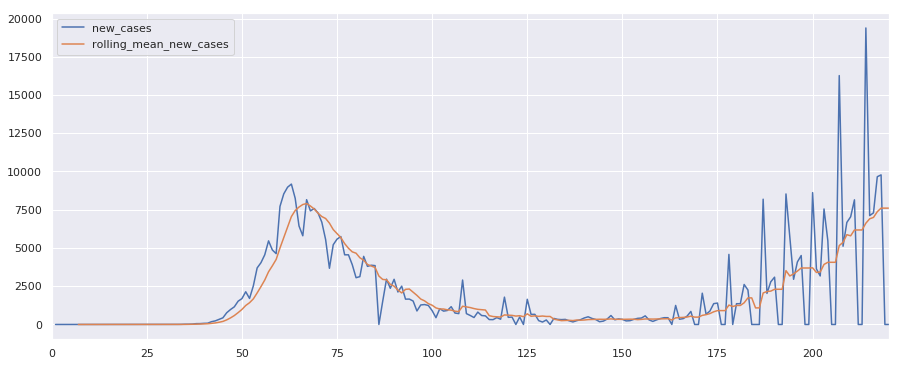

In [4]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

### RadarCOVID TEKs Extraction

In [5]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,075d6b0d-8e1f-b14a-4083-30e2f3b39b92
1,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,c29e54f9-beec-3dc1-c97b-63b37d328988
2,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,919cbe01-e19f-037a-9460-bded0852dfe5
3,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,421e9af1-43f8-183f-5211-538b976a54a7
4,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,107a2529-b759-57f6-51ad-b031417645cc


In [6]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-08-30,18
2020-08-29,20
2020-08-28,35
2020-08-27,59
2020-08-26,70


### RadarCOVID TEKs Dump

In [7]:
import datetime

extraction_date = datetime.datetime.utcnow().strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-31,2020-08-31@15
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-31,2020-08-31@15
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-31,2020-08-31@15
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-31,2020-08-31@15
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-31,2020-08-31@15


### RadarCOVID New TEKs

In [8]:
import glob

historic_tek_list_df = pd.DataFrame()

for path in glob.glob("Data/TEKs/Daily/RadarCOVID-TEKs-*.json"):
    extraction_tek_list_df = pd.read_json(path, lines=True)
    historic_tek_list_df = historic_tek_list_df.append(extraction_tek_list_df, sort=False)
    
historic_tek_list_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-29,NaN
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-29,NaN
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-29,NaN
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-29,NaN
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-29,NaN


In [9]:
tek_list_df = historic_tek_list_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{5b4b38d5-9293-9ea0-4622-d61b32940afc, 37effbb..."
2020-08-30,"{5b4b38d5-9293-9ea0-4622-d61b32940afc, 37effbb..."
2020-08-31,"{5b4b38d5-9293-9ea0-4622-d61b32940afc, 37effbb..."


In [10]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-08-29,NaN
1,2020-08-30,29.0
2,2020-08-31,29.0


In [11]:
new_tek_devices_df = historic_tek_list_df.copy()
new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(new_tek_devices_df.sample_date) + datetime.timedelta(1)
new_tek_devices_df["extraction_date"] = pd.to_datetime(new_tek_devices_df.extraction_date)

new_tek_devices_df = new_tek_devices_df[
    new_tek_devices_df.new_sample_extraction_date == new_tek_devices_df.extraction_date]
new_tek_devices_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
9,2020-08-28,"[757936ab-531c-4872-1d83-ce7a8d135211, 51d5fc9...",2020-08-29,NaN,2020-08-29
10,2020-08-29,"[1a509311-f96d-28f1-9d7d-414bf48272b9, 5bfad3a...",2020-08-30,NaN,2020-08-30
11,2020-08-30,"[075d6b0d-8e1f-b14a-4083-30e2f3b39b92, c29e54f...",2020-08-31,2020-08-31@15,2020-08-31


In [12]:
new_tek_devices_df.set_index("extraction_date", inplace=True)
new_tek_devices_df = new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).to_frame()
new_tek_devices_df.reset_index(inplace=True)
new_tek_devices_df.rename(columns={
    "extraction_date": "sample_date_string",
    "tek_list": "new_tek_devices"}, inplace=True)
new_tek_devices_df["sample_date_string"] = new_tek_devices_df.sample_date_string.dt.strftime("%Y-%m-%d")
new_tek_devices_df.head()

,sample_date_string,new_tek_devices
0,2020-08-29,27
1,2020-08-30,16
2,2020-08-31,18


### Data Merge

In [13]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count
0,2020-08-30,18.0,29.0
1,2020-08-29,20.0,NaN
2,2020-08-28,35.0,NaN
3,2020-08-27,59.0,NaN
4,2020-08-26,70.0,NaN


In [14]:
result_summary_df = result_summary_df.merge(new_tek_devices_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices
0,2020-08-30,18.0,29.0,16.0
1,2020-08-29,20.0,NaN,27.0
2,2020-08-28,35.0,NaN,NaN
3,2020-08-27,59.0,NaN,NaN
4,2020-08-26,70.0,NaN,NaN


In [15]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-08-30,18.0,29.0,16.0,439286.0,0.0,7604.571429
1,2020-08-29,20.0,NaN,27.0,439286.0,0.0,7604.571429
2,2020-08-28,35.0,NaN,NaN,439286.0,9779.0,7604.571429
3,2020-08-27,59.0,NaN,NaN,429507.0,9658.0,7371.571429
4,2020-08-26,70.0,NaN,NaN,419849.0,7296.0,6997.428571


In [16]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_devices_per_new_case"] = \
    result_summary_df.new_tek_devices / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_tek_device"] = \
    result_summary_df.new_tek_count / result_summary_df.new_tek_devices
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
0,2020-08-30,18.0,29.0,16.0,439286.0,0.0,7604.571429,0.002367,0.003813,0.002104,1.8125
1,2020-08-29,20.0,NaN,27.0,439286.0,0.0,7604.571429,0.002630,NaN,0.003550,NaN
2,2020-08-28,35.0,NaN,NaN,439286.0,9779.0,7604.571429,0.004602,NaN,NaN,NaN
3,2020-08-27,59.0,NaN,NaN,429507.0,9658.0,7371.571429,0.008004,NaN,NaN,NaN
4,2020-08-26,70.0,NaN,NaN,419849.0,7296.0,6997.428571,0.010004,NaN,NaN,NaN


In [17]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

## Report Results


### Summary Table

In [18]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "tek_count",
    "new_tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "new_tek_devices",
    "new_tek_devices_per_new_case",
    "new_tek_count_per_new_tek_device"]]
result_summary_df

,tek_count,new_tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
sample_date,,,,,,,,,
2020-08-31,NaN,29.0,NaN,NaN,NaN,NaN,18.0,NaN,1.611111
2020-08-30,18.0,29.0,0.0,7604.571429,0.002367,0.003813,16.0,0.002104,1.812500
2020-08-29,20.0,NaN,0.0,7604.571429,0.002630,NaN,27.0,0.003550,NaN
2020-08-28,35.0,NaN,9779.0,7604.571429,0.004602,NaN,NaN,NaN,NaN
2020-08-27,59.0,NaN,9658.0,7371.571429,0.008004,NaN,NaN,NaN,NaN
2020-08-26,70.0,NaN,7296.0,6997.428571,0.010004,NaN,NaN,NaN,NaN
2020-08-25,58.0,NaN,7117.0,6908.142857,0.008396,NaN,NaN,NaN,NaN
2020-08-24,48.0,NaN,19382.0,6622.000000,0.007249,NaN,NaN,NaN,NaN
2020-08-23,28.0,NaN,0.0,6177.285714,0.004533,NaN,NaN,NaN,NaN


### Summary Plots

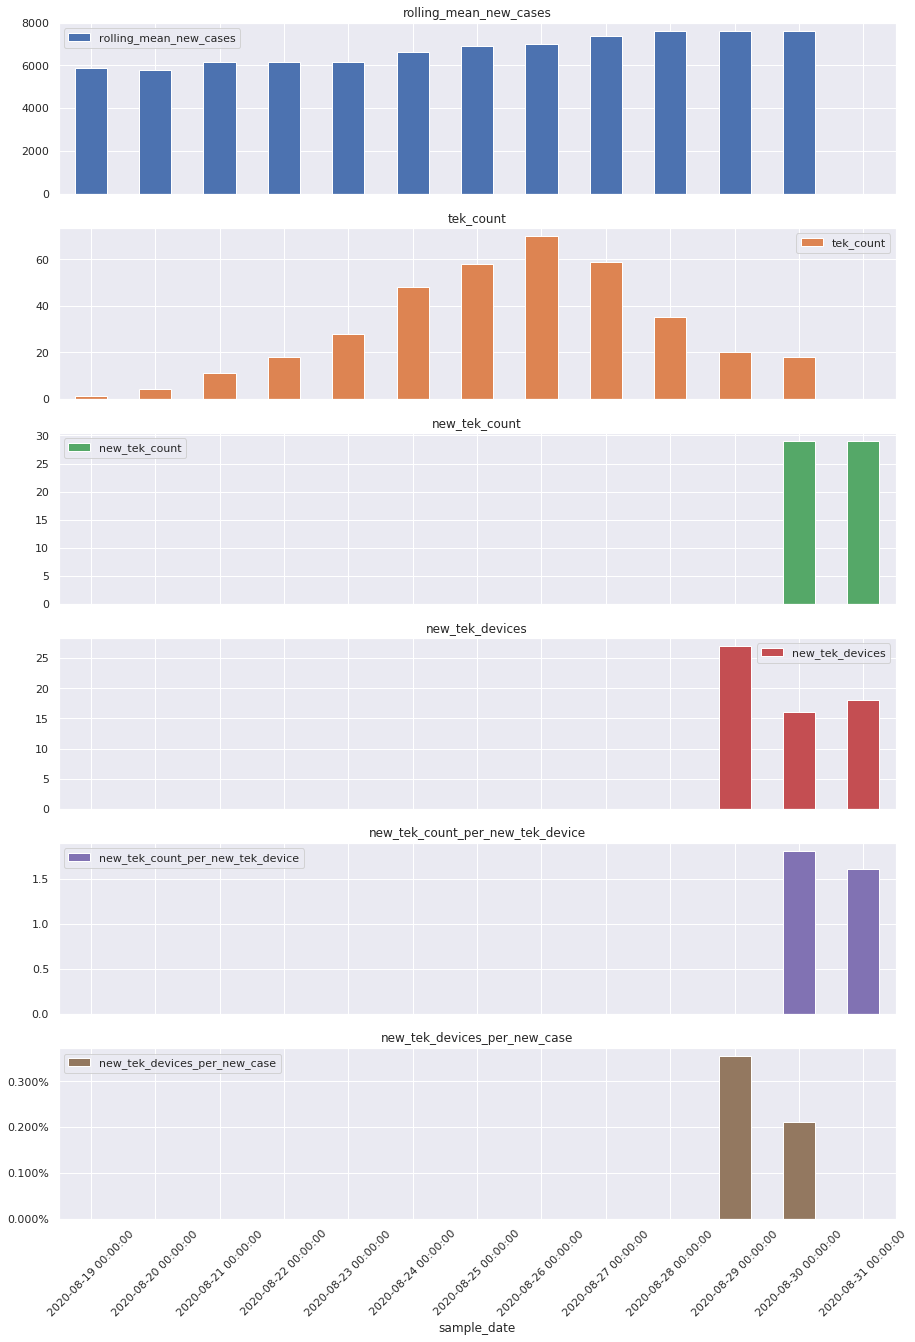

In [19]:
summary_ax_list = result_summary_df[[
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "new_tek_count_per_new_tek_device",
    "new_tek_devices_per_new_case"
]].sort_index(ascending=True).plot.bar(
    rot=45, subplots=True, figsize=(15, 22))
summary_ax_list[-1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

### Publish Results

In [20]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

summary_plots_image_path = save_temporary_plot_image(ax=summary_ax_list[0])
summary_table_image_path = save_temporary_dataframe_image(df=result_summary_df)

### Save Results

In [21]:
result_summary_df.to_csv("Data/Resources/Current/RadarCOVID-Report-Summary-Table.csv")
_ = shutil.copyfile(summary_plots_image_path, "Data/Resources/Current/RadarCOVID-Report-Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, "Data/Resources/Current/RadarCOVID-Report-Summary-Table.png")

### Publish on Twitter

In [22]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plot_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)

    extraction_date_result_summary_df = \
        result_summary_df[result_summary_df.index == extraction_date]
    status = (
        f"Report Update – {extraction_date_with_hour}: "
        f"https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/"
        f"RadarCOVID-Report/Hourly/RadarCOVID-Report-{extraction_date_with_hour}.ipynb"
        f"\n\n"
        f"Day Summary:\n"
        f"- New TEKs: {extraction_date_result_summary_df.new_tek_count.sum()}\n"
        f"- New Devices: {extraction_date_result_summary_df.new_tek_devices.sum()}")
    status = status.encode(encoding="utf-8")
    api.update_status(
        status=status,
        media_ids=[summary_plot_media.media_id, summary_table_media.media_id])